In [805]:
# 2D Examples
import sklearn.datasets as dt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

centers = [(0, -2),(-3, 1)]
cluster_std = [2.5, 2.5]

centers2 = [(-3, -5),(-6, -2)]
cluster_std2 = [1.5,1.5]

# centers = [(-2, 0),(-5, 3)]
# cluster_std = [2.5, 2.5]

# centers2 = [(-5, -3),(-8, 0)]
# cluster_std2 = [1.5,1.5]

# centers = [(-6, 2),(-9, 5)]
# cluster_std = [2.5, 2.5]

# centers2 = [(-9, -5),(-12, 2)]
# cluster_std2 = [1.5,1.5]


X1, y1 = dt.make_blobs(n_samples=100, cluster_std=cluster_std, centers=centers, n_features=2, random_state=1)
X2, y2 = dt.make_blobs(n_samples=200, cluster_std=cluster_std2, centers=centers2, n_features=2, random_state=1)


X = np.concatenate([X1, X2])
y = np.concatenate([y1, y2])

g1y1 = X1[y1==1]
g1y0 = X1[y1==0]
g2y1 = X2[y2==1]
g2y0 = X2[y2==0]

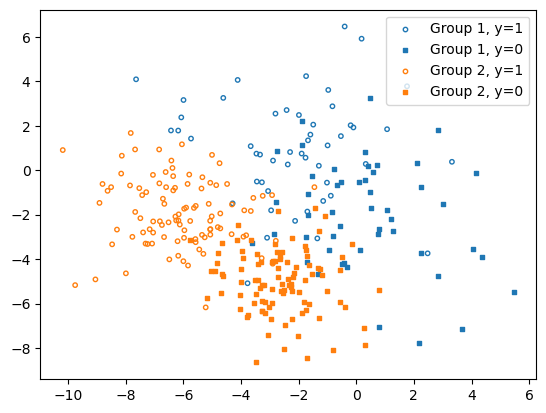

In [806]:
# Plot init seeds along side sample data
plt.figure(1)
plt.scatter(g1y1[:,0], g1y1[:,1], marker="o", facecolors='none', color = 'tab:blue', s=10)
plt.scatter(g1y0[:,0], g1y0[:,1], marker="s", color = 'tab:blue', s=10)
plt.scatter(g2y1[:,0], g2y1[:,1], marker="o", facecolors='none', color = 'tab:orange', s=10)
plt.scatter(g2y0[:,0], g2y0[:,1], marker="s", color = 'tab:orange', s=10)
plt.legend(['Group 1, y=1', 'Group 1, y=0', 'Group 2, y=1', 'Group 2, y=0'])
plt.show()

In [807]:
#clf = LogisticRegression(random_state=0, penalty=None,solver='newton-cg',max_iter=500).fit(X, y)
clf = LogisticRegression(random_state=0).fit(X, y)

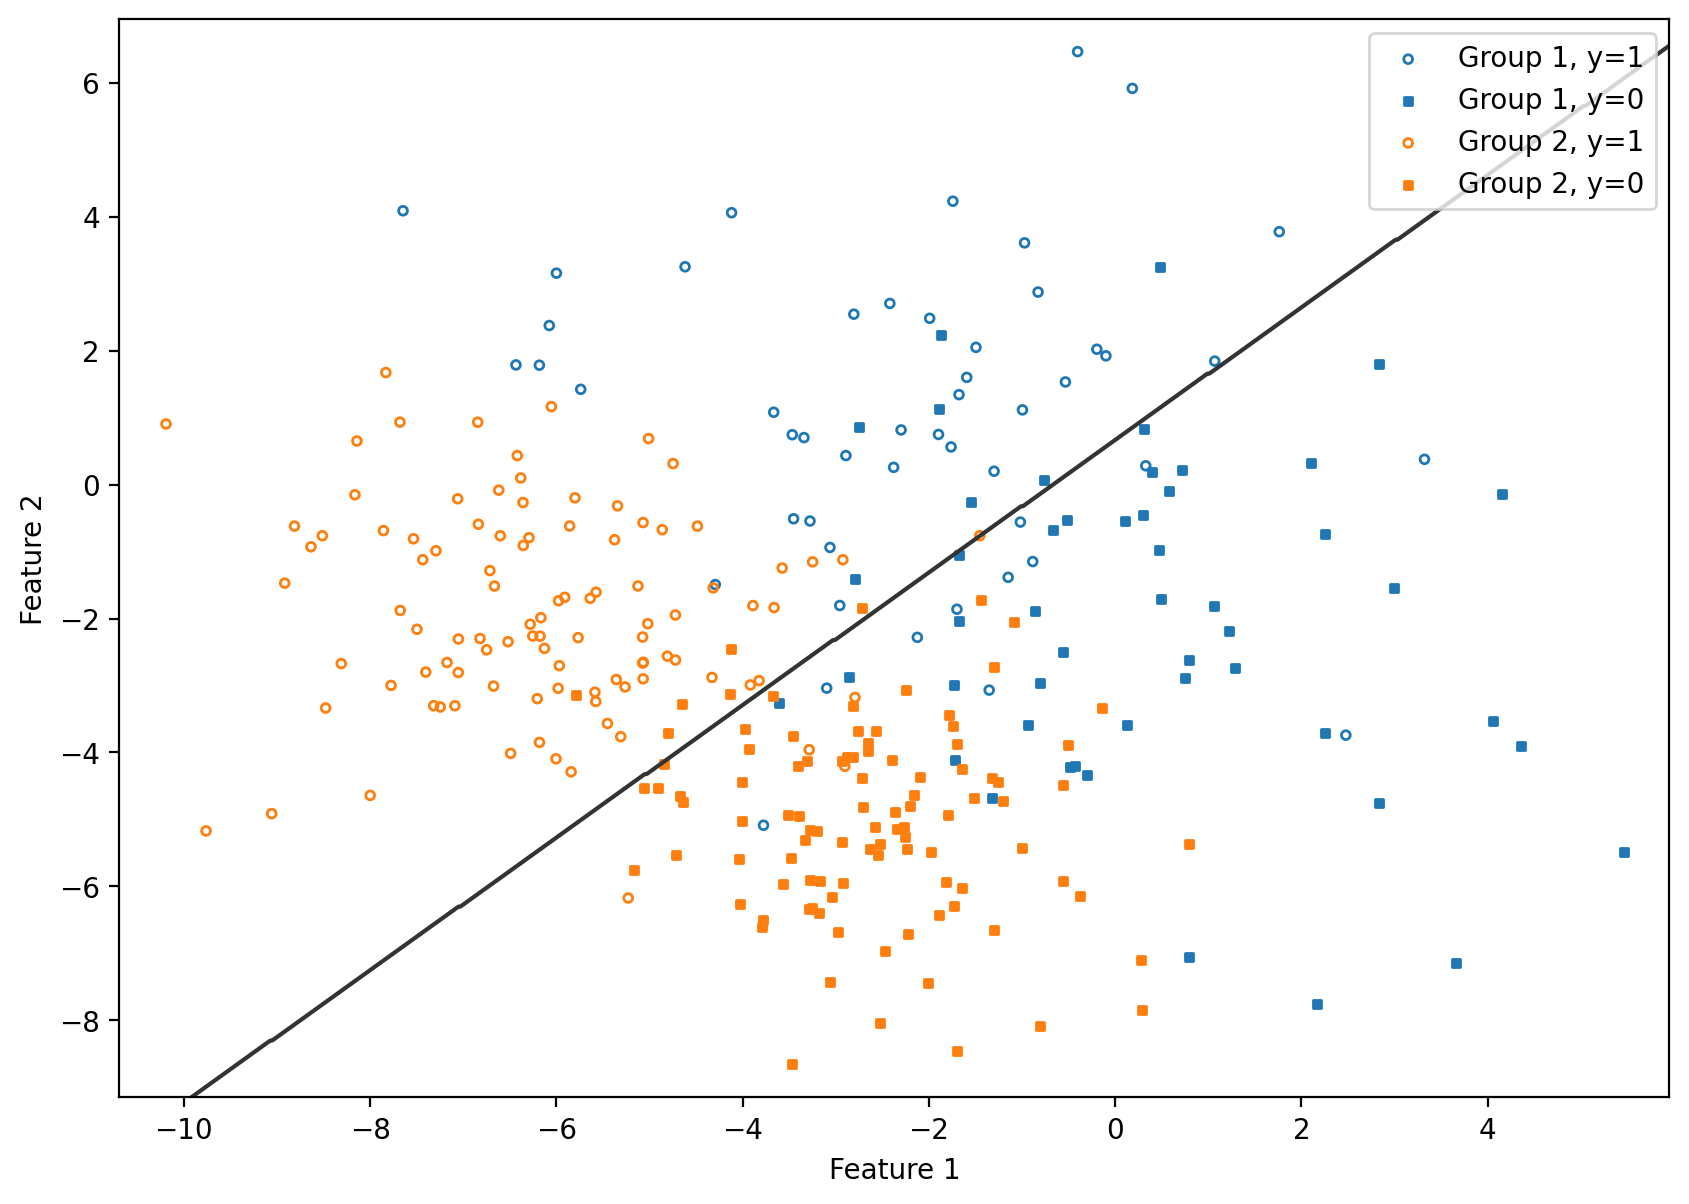

In [837]:
fig, ax1 = plt.subplots(dpi = 200,figsize = (10,7))

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


ax1.scatter(g1y1[:,0], g1y1[:,1], marker="o", facecolors='none', color = 'tab:blue', s=10)
ax1.scatter(g1y0[:,0], g1y0[:,1], marker="s", color = 'tab:blue', s=10)
ax1.scatter(g2y1[:,0], g2y1[:,1], marker="o", facecolors='none', color = 'tab:orange', s=10)
ax1.scatter(g2y0[:,0], g2y0[:,1], marker="s", color = 'tab:orange', s=10)
ax1.contour(xx, yy, Z, levels=[.5], cmap="Greys", vmin=0, vmax=.6)
ax1.legend(['Group 1, y=1', 'Group 1, y=0', 'Group 2, y=1', 'Group 2, y=0'])
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
#plt.title('Decision Boundary of Logistic Regression')

plt.savefig('Synthetic_logistic_reg_visualize.pdf', format='pdf', bbox_inches="tight")
# plt.show()

In [809]:
# evaluate fairness
# FPRg0 = np.sum(np.logical_and(clf.predict(X1) == 1, y1 == 0))/np.sum(y1 == 0)
# TPRg0 = np.sum(np.logical_and(clf.predict(X1) == 1, y1 == 1))/np.sum(y1 == 1)
# FPRg1 = np.sum(np.logical_and(clf.predict(X2) == 1, y2 == 0))/np.sum(y2 == 0)
# TPRg1 = np.sum(np.logical_and(clf.predict(X2) == 1, y2 == 1))/np.sum(y2 == 1)
# print(FPRg0, TPRg0, FPRg1, TPRg1)
# ave_abs_odds_diff = (np.abs(FPRg0 - FPRg1) + np.abs(TPRg0 - TPRg1))/2
# ave_abs_odds_diff

In [810]:
epsilons = np.linspace(-0.5, 0.5, 200)
losses = []
ave_abs_odds_diffs = []
perturbed_weights_arr = []
for epsilon in epsilons:
    perturbed_weights = clf.coef_.copy() + epsilon 
    perturbed_weights_arr.append(perturbed_weights)
    logits = np.dot(X, perturbed_weights.T) + clf.intercept_
    probs = 1 / (1 + np.exp(logits))
    loss = -np.mean(y * np.log(probs) + (1 - y) * np.log(1 - probs))
    losses.append(loss)

    probs_g0 = 1 / (1 + np.exp(np.dot(X1, perturbed_weights.T) + clf.intercept_))
    probs_g1 = 1 / (1 + np.exp(np.dot(X2, perturbed_weights.T) + clf.intercept_))
    FPRg0 = np.sum(np.logical_and(np.squeeze(probs_g0 > 0.5), y1 == 0))/np.sum(y1 == 0)
    TPRg0 = np.sum(np.logical_and(np.squeeze(probs_g0 > 0.5), y1 == 1))/np.sum(y1 == 1)
    FPRg1 = np.sum(np.logical_and(np.squeeze(probs_g1 > 0.5), y2 == 0))/np.sum(y2 == 0)
    TPRg1 = np.sum(np.logical_and(np.squeeze(probs_g1 > 0.5), y2 == 1))/np.sum(y2 == 1)
    ave_abs_odds_diff = (np.abs(FPRg0 - FPRg1) + np.abs(TPRg0 - TPRg1))/2
    ave_abs_odds_diffs.append(ave_abs_odds_diff)

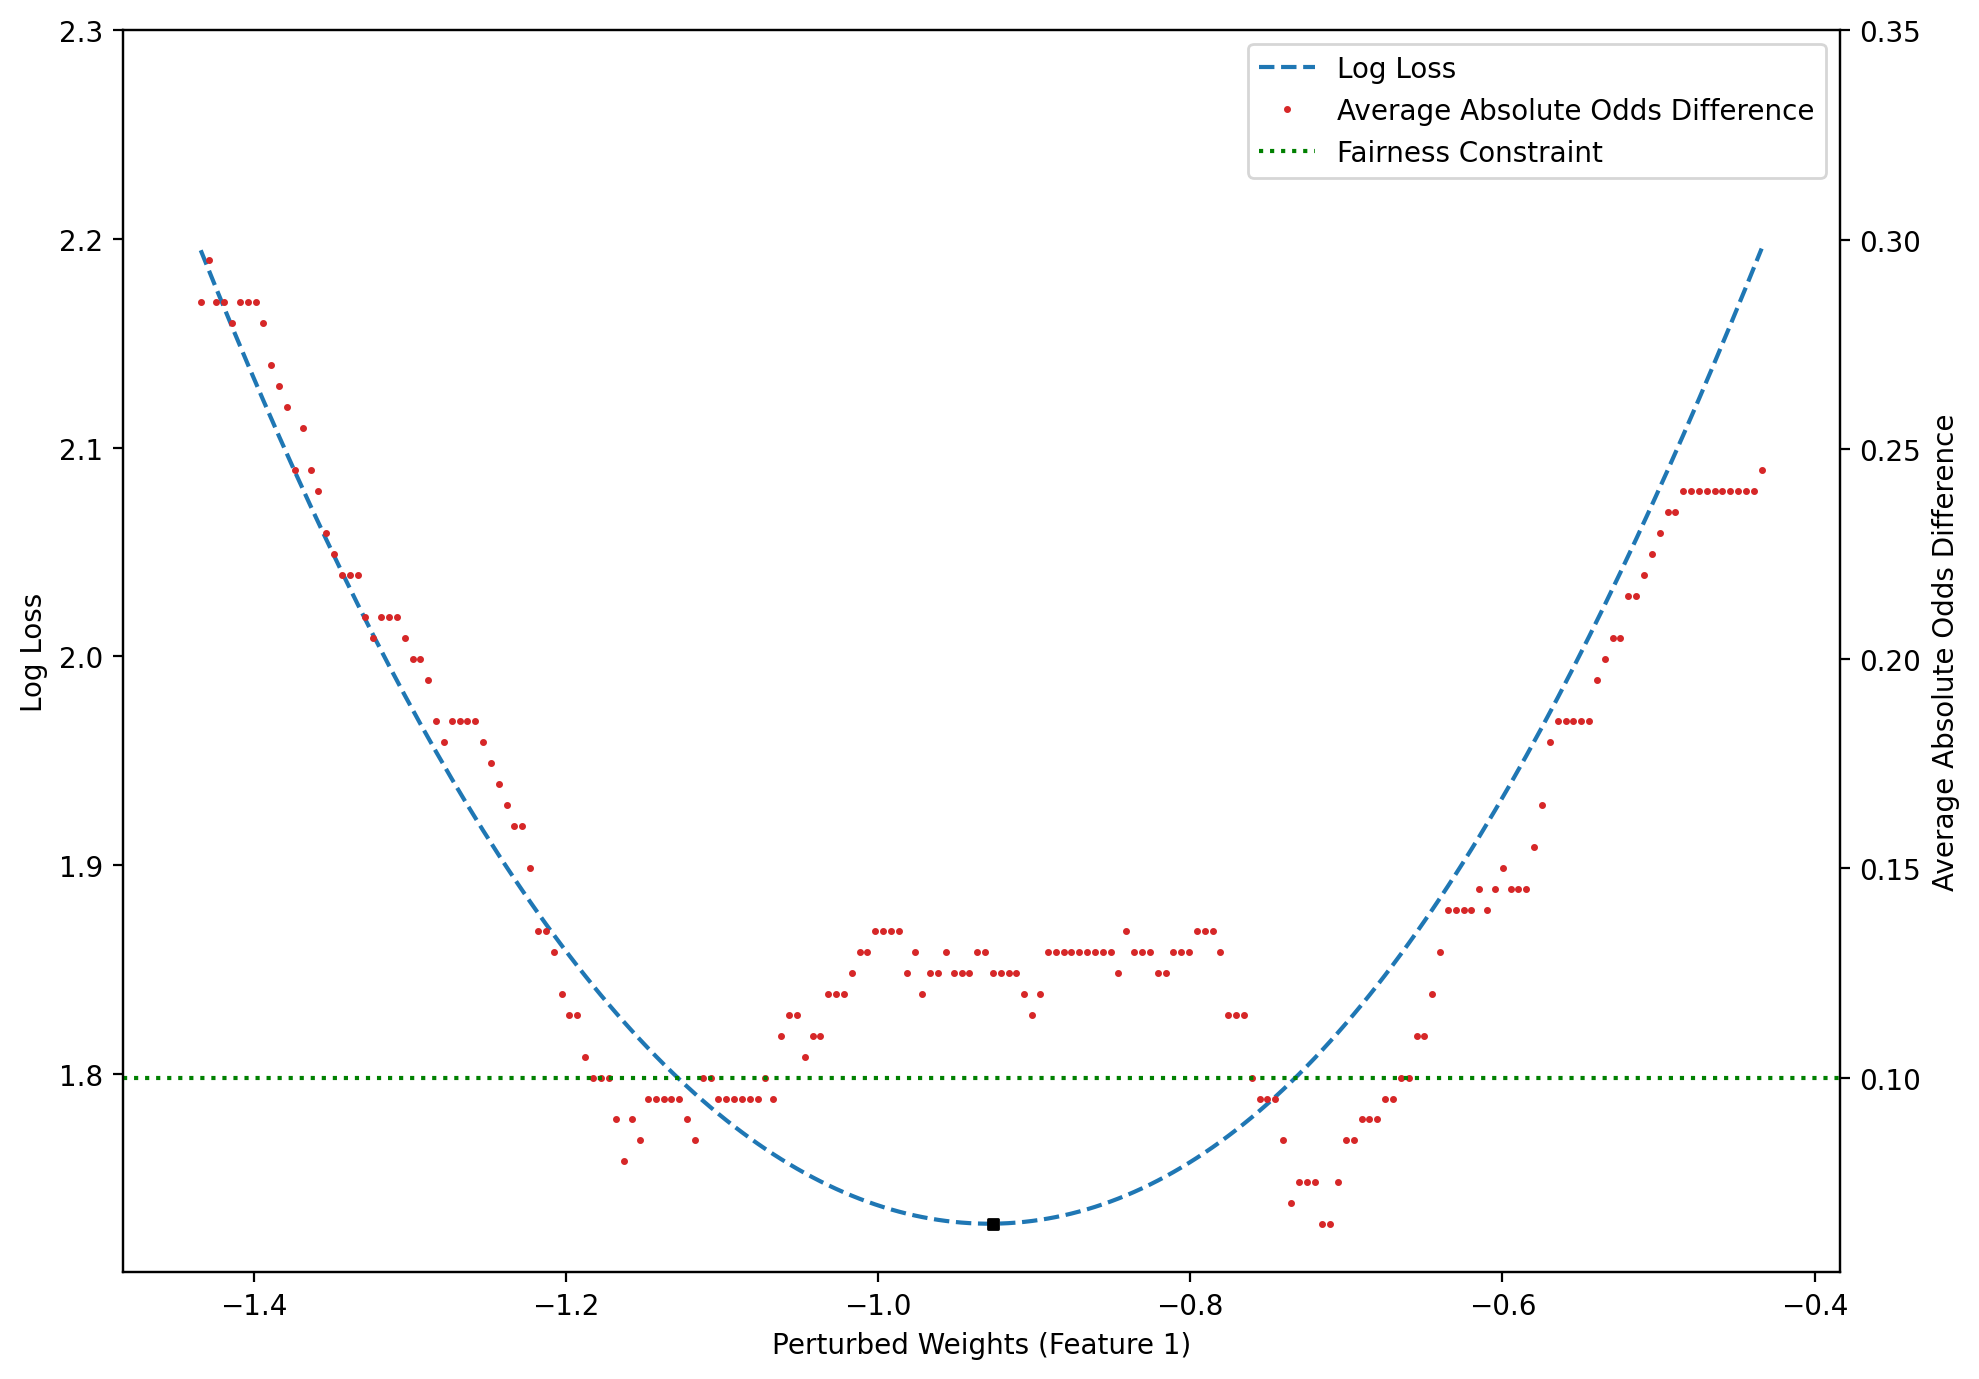

In [811]:
fig, ax1 = plt.subplots(dpi = 200,figsize = (10,7))

ax1.plot(np.squeeze(perturbed_weights_arr)[:,0],np.squeeze(losses),  '--',markersize=0.2, label = 'Log Loss',c='tab:blue')
ax1.set_xlabel('Perturbed Weights (Feature 1)')
ax1.set_ylabel('Log Loss')
max_y_value_ax1 = 2.3
ax1.set_ylim([None, max_y_value_ax1])

ax2 = ax1.twinx()

ax2.plot(np.squeeze(perturbed_weights_arr)[:,0],np.squeeze(ave_abs_odds_diffs),  '.',markersize=3, label = 'Average Absolute Odds Difference',c='tab:red')
ax2.set_ylabel('Average Absolute Odds Difference')
max_y_value_ax2 = 0.35
ax2.set_ylim([None, max_y_value_ax2])

min_loss_index = np.argmin(losses)
min_loss_weight = np.squeeze(perturbed_weights_arr)[:,0][min_loss_index]
min_loss = np.min(losses)
ax1.scatter(min_loss_weight, min_loss, color='black', marker="s", label='Lowest Loss', s = 15, zorder=10)

ax2.axhline(y=0.1, color='green', linestyle=':', label='Fairness Constraint')

# Add legends for both curves
lines = ax1.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

fig.tight_layout()
plt.savefig('Synthetic_logistic_reg.pdf', format='pdf', bbox_inches="tight")


In [831]:
epsilon_valid = epsilons[ave_abs_odds_diffs < np.ones(len(ave_abs_odds_diffs))*0.1]
epsilon_valid_pos = epsilon_valid[epsilon_valid > 0][0]
print(epsilon_valid_pos)
epsilons_valid_neg = epsilon_valid[epsilon_valid < 0][-1]
print(epsilons_valid_neg)

0.1733668341708543
-0.13316582914572866


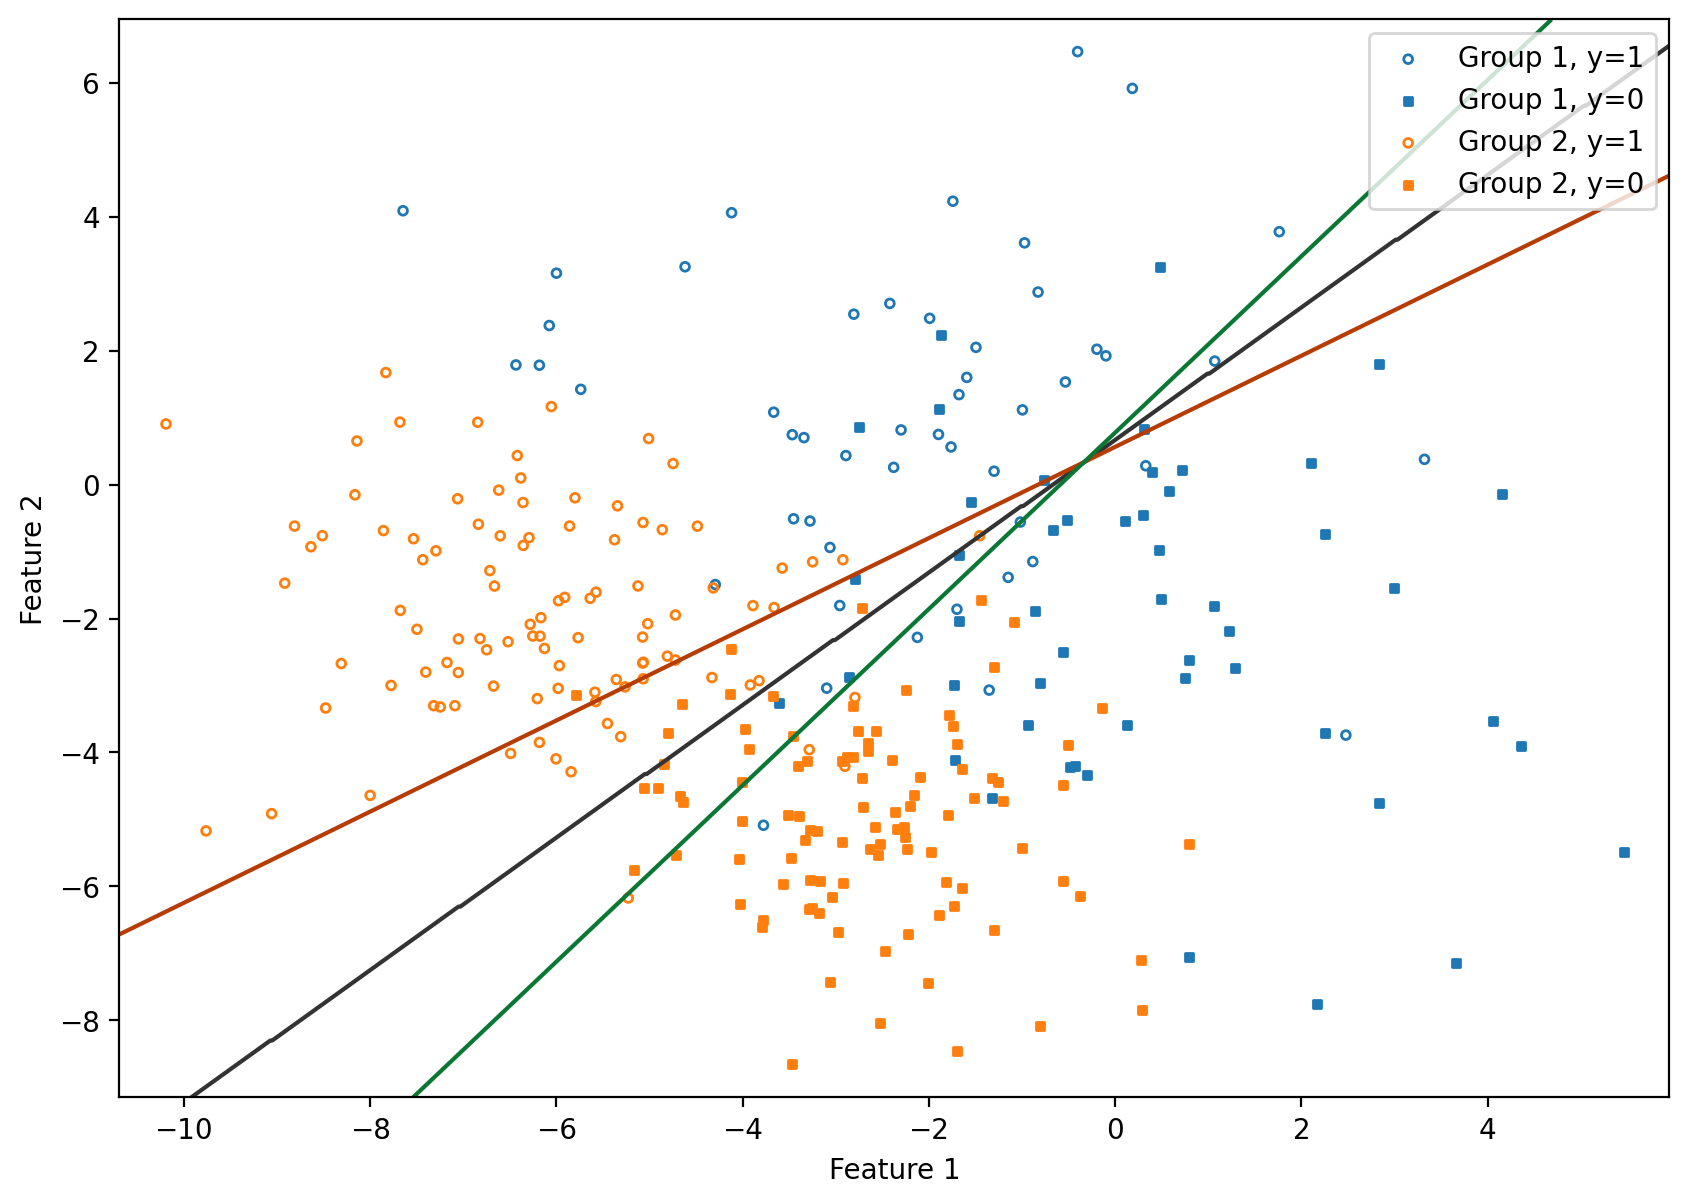

In [835]:
fig, ax1 = plt.subplots(dpi = 200,figsize = (10,7))

# original decision boundary
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax1.contour(xx, yy, Z, levels=[.5], cmap="Greys", vmin=0, vmax=.6)

# decision boundary with perturbed weights
perturbed_weights = clf.coef_.copy() + epsilon_valid_pos
Zpos = 1 / (1 + np.exp(np.dot(np.c_[xx.ravel(), yy.ravel()], perturbed_weights.T) + clf.intercept_))
Zpos = Zpos.reshape(xx.shape)
ax1.contour(xx, yy, Zpos, levels=[.5], cmap="Oranges", vmin=0, vmax=.6)

perturbed_weights = clf.coef_.copy() + epsilons_valid_neg
Zneg = 1 / (1 + np.exp(np.dot(np.c_[xx.ravel(), yy.ravel()], perturbed_weights.T) + clf.intercept_))
Zneg = Zneg.reshape(xx.shape)
ax1.contour(xx, yy, Zneg, levels=[.5], cmap="Greens", vmin=0, vmax=.6)

ax1.scatter(g1y1[:,0], g1y1[:,1], marker="o", facecolors='none', color = 'tab:blue', s=10)
ax1.scatter(g1y0[:,0], g1y0[:,1], marker="s", color = 'tab:blue', s=10)
ax1.scatter(g2y1[:,0], g2y1[:,1], marker="o", facecolors='none', color = 'tab:orange', s=10)
ax1.scatter(g2y0[:,0], g2y0[:,1], marker="s", color = 'tab:orange', s=10)

ax1.legend(['Group 1, y=1', 'Group 1, y=0', 'Group 2, y=1', 'Group 2, y=0'])
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

plt.savefig('Synthetic_logistic_reg_visualize_3models.pdf', format='pdf', bbox_inches="tight")
plt.show()

In [733]:
print(np.min(losses))

1.9667253811583318


In [594]:
# probabilities = clf.predict_proba(X)  # Predict probabilities for each class
# loss = -np.mean(y * np.log(probabilities[:, 1]) + (1 - y) * np.log(probabilities[:, 0]))
# print("Loss:", loss)

logits = np.dot(X, clf.coef_.T) + clf.intercept_
probs = 1 / (1 + np.exp(-logits))
loss = -np.mean(y * np.log(probs) + (1 - y) * np.log(1-probs))
print("Loss:", loss)

perturbed_weights = clf.coef_.copy() + epsilons[min_loss_index] 
logits = np.dot(X, perturbed_weights.T) + clf.intercept_
probs = 1 / (1 + np.exp(logits))
loss = -np.mean(y * np.log(probs) + (1 - y) * np.log(1 - probs))
print("Loss:", loss)

Loss: 1.8651580750047798
Loss: 1.73347094229084
